## 번역기를 만들어 보자

- 학습 목표
    - 다양한 RNN의 구성을 알아보기
    - 인코더와 디코더 구조의 필요성 이해하기
    - 교사 강요(teacher forcing)의 원리 알기
    - 훈련 단계와 추론 단계(inference)의 차이 알기

## 번역기 만들기 (1) 데이터 전처리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

해당 화일을 데이터 프레임으로 읽어오기

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 178009


,eng,fra,cc
72726,They've changed the rules.,Ils ont changé les règles.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
122071,I think I look fat in these jeans.,"Je pense que j'ai l'air grosse, dans ce jean.",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
110002,I am very sorry for what I said.,Je suis vraiment désolé pour ce que j'ai dit.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
4822,You're fired.,Tu es viré.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
60499,Do we have enough chairs?,A-t-on suffisamment de chaises ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


세번째 열은 불필요하므로 제거하고, 훈련 데이터는 5만개의 샘플로 줄이기

In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
5632,I love nature.,J'adore la nature.
28086,You're the teacher.,C'est vous la professeur.
43512,It's easy to get lost.,On se perd facilement.
37374,No one's blaming you.,Personne ne vous fait de reproche.
13705,Are you my enemy?,Es-tu mon ennemi ?


seq2seq 동작을 위해서 디코더의 입력과 예측에는 시작 토큰 <sos>와 종료 토큰 <eos>가 필요합니다. 이번에는 각각 \t와 \n을 사용하겠습니다. 두 토큰을 추가해줍니다.

In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
38198,They lost everything.,\t Ils ont tout perdu. \n
7712,He looks young.,\t Il a l'air jeune. \n
42629,I usually get up at 8.,\t Je me lève généralement à huit heures. \n
1027,We'll try.,\t Nous tenterons. \n
21198,The street is wet.,\t La rue est mouillée. \n


이제 단어장(vocabulary)을 만들고, 각 단어에 부여된 고유한 정수로 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정을 거치겠습니다. 이때 영어와 프랑스어는 사용하는 언어가 다르므로 단어장을 별도로 만들어줍니다. 그리고 정상적으로 정수 시퀀스로 변환되었는지 3개의 행을 출력합니다.

In [5]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 3, 8], [10, 5, 8], [10, 5, 8]]

In [6]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[11, 1, 19, 4, 1, 33, 1, 12],
 [11, 1, 3, 4, 13, 7, 5, 1, 33, 1, 12],
 [11, 1, 3, 4, 13, 7, 5, 14, 1, 12]]

단어장의 크기를 변수로 저장해줍니다. 0번 토큰을 고려하여 +1을 하고 저장해줍니다.

In [7]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 51
프랑스어 단어장의 크기 : 73


이제 영어 데이터와 프랑스어 데이터의 최대 길이를 각각 구해보겠습니다. 이는 패딩(< pad >)을 위함입니다. 모델에 입력될 영어, 프랑스어 시퀀스의 길이가 일정해야 하므로, 최대 길이로 맞추고 남는 시퀀스 뒷부분을 패딩으로 채우게 됩니다.

In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 23
프랑스어 시퀀스의 최대 길이 76


전체적인 통계 정보를 한꺼번에 출력해봅시다.

In [9]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 51
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 23
프랑스어 시퀀스의 최대 길이 76


인코더의 입력으로 사용되는 영어 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비해야 합니다. 하나는 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것입니다. 그리고 다른 하나는 이전 스텝에서 언급했던 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위한 것입니다.

이때, 디코더의 입력으로 사용할 시퀀스는 < eos >토큰이 필요가 없고, 디코더의 출력과 비교할 시퀀스는 < sos >가 필요가 없기 때문입니다. 가령, 영어로 'I am a person'이라는 문장을 프랑스어 'Je suis une personne'로 번역하는 번역기를 만든다고 해봅시다. 훈련 과정에서 디코더는 '< sos > Je suis une personne'를 입력받아서 'Je suis une personne < eos >'를 예측하도록 훈련되므로, 이런 방식으로 생성된 두가지 버전의 시퀀스를 준비해야 합니다.

In [10]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

디코더의 입력과 출력을 각각 출력해봅시다.

In [11]:
print(decoder_input[:3])
print(decoder_target[:3])

[[11, 1, 19, 4, 1, 33, 1], [11, 1, 3, 4, 13, 7, 5, 1, 33, 1], [11, 1, 3, 4, 13, 7, 5, 14, 1]]
[[1, 19, 4, 1, 33, 1, 12], [1, 3, 4, 13, 7, 5, 1, 33, 1, 12], [1, 3, 4, 13, 7, 5, 14, 1, 12]]


디코더의 입력의 경우에는 숫자 12(< eos > 토큰)가 제거되었고, 디코더의 출력의 경우에는 숫자 11(< sos > 토큰)이 제거되었습니다. 이제 패딩을 진행합니다. 패딩을 진행하면 모든 샘플들의 길이가 정해준 길이로 동일하게 변환됩니다. 여기서는 아까 저장해두었던 가장 긴 샘플의 길이인 max_eng_seq_len, max_fra_seq_len를 각각 사용하였습니다.

이렇게 되면 영어 데이터의 모든 샘플들은 max_eng_seq_len의 길이를 가지고, 프랑스어의 모든 샘플들은 max_fra_seq_len의 길이가 되겠죠?



In [12]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 23)
프랑스어 입력데이터의 크기(shape) : (50000, 76)
프랑스어 출력데이터의 크기(shape) : (50000, 76)


모든 샘플들의 길이가 동일하게 변환된 것을 알 수 있습니다. 모든 샘플들의 길이가 동일하게 변환되는 과정에서 정해준 길이보다 짧은 데이터들은 뒤에 0(< pad >)으로 채워집니다. 인코더의 샘플 하나만 출력해볼까요?

In [13]:
print(encoder_input[0])

[19  3  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


앞서 [19, 3, 8]이라는 3개의 단어만 있단 샘플이 뒤에 0이 채워지면서 max_eng_seq_len의 값인 23의 길이를 가지게 되었습니다. 이제 각 정수에 대해서 벡터화 방법으로 원-핫 인코딩을 선택합니다.

In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 23, 51)
프랑스어 입력데이터의 크기(shape) : (50000, 76, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 76, 73)


원-핫 인코딩을 하고나서의 데이터의 크기는 (샘플의 수 × 샘플의 길이 × 단어장의 크기)가 됩니다. 원-핫 인코딩은 각 정수를 단어장의 크기를 가지는 원-핫 벡터로 인코딩하는 과정이기 때문입니다.

마지막으로, 훈련과정의 validation을 위해 위에서 생성한 데이터 50000건 중 3000건만 검증데이터로 삼고, 나머지를 학습데이터로 삼겠습니다.



In [17]:
n_of_val = 3000

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습 데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

print('영어 검증 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 검증 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 검증 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 데이터의 크기(shape) : (50000, 23, 51)
프랑스어 입력데이터의 크기(shape) : (50000, 76, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 76, 73)
영어 학습 데이터의 크기(shape) : (47000, 23, 51)
프랑스어 학습 입력데이터의 크기(shape) : (47000, 76, 73)
프랑스어 학습 출력데이터의 크기(shape) : (47000, 76, 73)
영어 검증 데이터의 크기(shape) : (3000, 23, 51)
프랑스어 검증 입력데이터의 크기(shape) : (3000, 76, 73)
프랑스어 검증 출력데이터의 크기(shape) : (3000, 76, 73)


## 번역기 만들기 (2) 모델 훈련하기

In [18]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

print('⏳')

⏳


먼저 인코더를 설계해볼까요? 인코더는 디코더보다 상대적으로 간단합니다. LSTM 셀을 설계하고나서 문장을 입력받으면 LSTM 셀이 마지막 time step의 hidden state와 cell state를 전달받아서 저장해줍니다. 앞서 인코더의 마지막 hidden state를 디코더의 첫번째 hidden state로 사용한다고 했었지요? 일반적인 기본 RNN의 경우에는 그것이 맞지만, 기본 RNN보다 좀 더 복잡한 LSTM의 경우에는 hidden state뿐만 아니라, cell sate라는 것이 존재합니다.

그래서 인코더 LSTM 셀의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해주어야 합니다.

In [19]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

위의 코드를 한 줄, 한 줄 파악해볼게요.

첫번째 줄 : 우선 LSTM의 입력 텐서를 정의해줍니다. 입력 문장을 저장하게 될 변수 텐서입니다.

두번째 줄 : 256의 hidden_size를 가지는 LSTM 셀을 만들어줍니다. LSTM의 수용력(capacity)를 의미합니다. return_state = True를 해서 hidden state와 cell state를 리턴받을 수 있도록 합니다.

세번째 줄 : 입력 텐서를 입력으로 마지막 time step의 hidden state와 cell state를 결과로 받습니다.

네번째 줄 : 마지막 time step의 hidden state와 cell state를 encoder_states라는 하나의 변수에 저장해뒀습니다. 이를 디코더에 전달하면 되겠네요.

이제 디코더를 설계해볼까요? 디코더도 인코더랑 몇 가지 세부 사항을 제외하고 거의 똑같습니다.

In [20]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

세번째 줄을 보면 디코더의 인자로 initial_state가 추가되었는데요. LSTM 셀의 초기 상태를 정의해줄 수 있는 인자입니다. 여기서는 이전에 저장한 인코더의 마지막 time step의 hidden state와 cell state를 사용하였습니다. 디코더의 출력층을 설계해줍니다.

In [21]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

매 time step마다의 다중 클래스 분류 문제이므로 프랑스어 단어장으로부터 한 가지 문자만 선택하도록 합니다. Dense의 인자로 프랑스어 단어장의 크기를 기재하고, 활성화 함수로 소프트맥스 함수를 사용. 최종적으로 인코더와 디코더를 연결해서 하나의 모델로 만들어줍니다. Model의 Input과 Output의 정의를 유심히 살펴 주세요.

In [22]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 315392      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [23]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
368/368 [==============================] - 6s 16ms/step - loss: 0.9152 - val_loss: 0.8011
Epoch 2/50
368/368 [==============================] - 6s 15ms/step - loss: 0.5708 - val_loss: 0.6652
Epoch 3/50
368/368 [==============================] - 5s 14ms/step - loss: 0.4725 - val_loss: 0.5699
Epoch 4/50
368/368 [==============================] - 5s 14ms/step - loss: 0.4132 - val_loss: 0.5226
Epoch 5/50
368/368 [==============================] - 5s 14ms/step - loss: 0.3751 - val_loss: 0.4824
Epoch 6/50
368/368 [==============================] - 5s 14ms/step - loss: 0.3476 - val_loss: 0.4553
Epoch 7/50
368/368 [==============================] - 5s 14ms/step - loss: 0.3271 - val_loss: 0.4305
Epoch 8/50
368/368 [==============================] - 5s 14ms/step - loss: 0.3100 - val_loss: 0.4180
Epoch 9/50
368/368 [==============================] - 5s 14ms/step - loss: 0.2962 - val_loss: 0.4081
Epoch 10/50
368/368 [==============================] - 5s 14ms/step - loss: 0.2847 - val_lo

## 번역기 만들기 (3) 모델 테스트하기

seq2seq는 훈련할 때와 테스트 단계의 동작이 다릅니다. 이를 위해서 테스트 단계의 디코더 모델은 설계를 다시 해줄 필요가 있습니다. 물론 이전에 학습된 디코더 모델의 레이어는 그대로 사용합니다. 왜 이렇게 번거로운 과정이 생기는 것일까요? Text Generator 모델을 만들어 보신 분이라면 알 수 있습니다. 훈련시에는 학습해야 할 타겟 문장을 디코더 모델의 입력, 출력 시퀀스로 넣어 주고, 디코더 모델이 타겟 문장을 한꺼번에 출력하게 할 수 있습니다. 그러나 테스트 단계에서는 그럴 수가 없습니다. 하나의 문장을 만들어 내기 위해 루프를 돌면서 단어를 하나씩 차례차례 예측해서, 예측한 단어가 다시 다음 단어를 예측할 때 사용되는 입력으로 재사용되는 과정이 진행되기 때문입니다.

정리하면, 테스트 단계에서의 디코더의 동작 순서는 아래와 같습니다.

1. 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
2. 토큰인 '\t'를 디코더에 입력한다.
3. 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 한다.
4. 3을 반복하다가 토큰인 '\n'가 예측되면 이를 중단한다.

이를 구현하기 위해서 훈련 과정에서와의 차이점은 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 사용하는 단계를 추가하기 위해서 루프를 돌며 디코더의 LSTM 셀을 마치 수동 제어하는 느낌으로 설계해야 합니다. 코드가 좀 더 길어지게 되는데요.

우선 인코더를 정의합니다. encoder_inputs와 encoder_states는 이미 정의한 것들을 재사용합니다.

In [24]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 51)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 315392    
Total params: 315,392
Trainable params: 315,392
Non-trainable params: 0
_________________________________________________________________


이제 디코더를 설계합니다.

In [25]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

훈련 과정에서의 디코더보다 코드가 좀 더 길어졌죠? 이전 time step의 출력 결과를 현재 time step의 입력으로 사용하기 위해서 디코더 LSTM 셀의 동작을 좀 더 세분화해서 구현했습니다. 동작 자체는 이후에 구현할 def decode_sequence()에서 좀 더 자세히 다루겠습니다.

디코더의 출력층을 재설계해줍니다.

In [26]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary)을 준비해 둡니다. 테스트 결과를 해석하기 위해선 다시 사전이 필요하겠죠? 우리는 이전 스텝에서 문장을 숫자 인덱스로 바꾸는 Tokenizer를 만들면서 자동으로 만들어진 사전을 이미 가지고 있습니다.

In [27]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

이제 예측 과정을 위한 함수 decode_sequence()를 구현합니다. decode_sequence()의 입력으로 들어가는 것은 번역하고자 하는 문장의 정수 시퀀스입니다. decode_sequence() 내부에는 인코더를 구현한 encoder_model이 있어서 이 모델에 번역하고자 하는 문장의 정수 시퀀스인 'input_seq'를 입력하면, encoder_model은 마지막 시점의 hidden state를 리턴합니다.

states_value = encoder_model.predict(input_seq)

이 hidden state는 디코더의 첫번째 시점의 hidden state가 되고, 디코더는 이제 번역 문장을 완성하기 위한 예측 과정을 진행합니다. 디코더의 예측 과정에서는 이전 시점에서 예측한 단어를 디코더의 현재 시점의 입력으로 넣어주는 작업을 진행합니다. 그리고 이 작업은 종료를 의미하는 종료 토큰을 만나거나, 주어진 최대 길이를 넘을 때까지 반복합니다.

In [28]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

이렇게 구현한 함수를 임의의 인덱스의 번역하고자하는 문장 샘플을 입력하여,

출력 결과를 테스트해보겠습니다.

In [29]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Run!
정답 문장:  Cours ! 
번역기가 번역한 문장:  cours-tu ! 
-----------------------------------
입력 문장: I left.
정답 문장:  Je suis partie. 
번역기가 번역한 문장:  je suis parti. 
-----------------------------------
입력 문장: Call us.
정답 문장:  Appelez-nous ! 
번역기가 번역한 문장:  appelle ça ! 
-----------------------------------
입력 문장: How nice!
정답 문장:  Comme c'est gentil ! 
번역기가 번역한 문장:  comme c'est bizarre ! 
-----------------------------------
입력 문장: Turn left.
정답 문장:  Tourne à gauche. 
번역기가 번역한 문장:  tourne ! 


일부 정답 문장과 다른 번역을 하는 경우도 있지만, 대체적으로 정답 문장과 거의 비슷한 번역을 확인할 수 있습니다.

## 프로젝트 : 단어 Level로 번역기 업그레이드하기

실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [30]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 178009


,eng,fra,cc
140537,The problem is too difficult to solve.,Le problème est trop difficile à résoudre.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
13656,Are you Catholic?,Es-tu catholique ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
70386,I work out whenever I can.,Je m'exerce chaque fois que je peux.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
97735,I don't walk anywhere anymore.,Je ne marche plus nulle part.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
143921,Some believe Nessie lives in this lake.,Certains croient que Nessie vit dans ce lac.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [31]:
lines = lines[['eng', 'fra']][:33000] # 33,000개 샘플만 사용
lines.sample(5)

,eng,fra
27609,Why come to me now?,Pourquoi venir à moi maintenant ?
53,I paid.,J’ai payé.
17227,We're on our own.,Nous sommes seuls.
8480,I'm fascinated.,Je suis fasciné.
9944,You're my boss.,Vous êtes mon patron.


## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

### 1. 구두점(Punctuation)을 단어와 분리해주세요.
일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization)이라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요. 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.

예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면

['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로

좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.

!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다.

이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!

분리 후 : he is a Good boy !


### 2. 소문자로 바꿔주세요.
기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !

변환 후 : he is a good boy !


### 3. 띄어쓰기 단위로 토큰를 수행하세요.
띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

토큰화 전 : 'he is a good boy !'

토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [39]:
lines.sample(5)

,eng,fra
23646,he is a bad person .,c est une mauvaise personne .
15088,i need new tires .,il me faut des pneus neufs .
32058,they know who he is .,elles savent qui c est .
4783,you may swim .,tu as la permission de nager .
24005,i am not a teacher .,je ne suis pas enseignant .


In [40]:
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 

def preprocess_sentence(sentence) :
    
    # 전처리 부분

    # 구두점을 단어와 분리를 시켜본다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)       # 소문자, 대문자 알파벳, 구분자를 제외한 문자 공백으로 치환
    sentence = re.sub(r"\s+", r" ", sentence)                 # 여러 공백문자들을 하나의 공백으로 치환
    
    sentence = sentence.lower()                               # 모두 소문자로 변환
    
    return sentence

lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence(x))
lines.sample(5)

,eng,fra
29558,i do not understand .,je ne comprends pas .
29906,i like boston a lot .,j aime beaucoup boston .
32986,what time is it now ?,quelle heure est il pr sent ?
20930,stop it right now !,arr tez imm diatement !
18624,he had no coat on .,il ne portait pas de manteau .


## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 가 필요합니다.

예를 들어 번역 문장이 Courez!이었다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['', 'courez', '!']

레이블 시퀀스 : ['courez', '!', ']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!

Step 1을 수행하는 중간에 수행해도 상관없습니다.

In [41]:
### 시작 토큰과 종료 토큰 추가
sos_token = '<sos>'
eos_token = '<eos>'
lines.fra = lines.fra.apply(lambda x : sos_token + ' ' + x + ' ' + eos_token)
print('전체 샘플의 수 : ', len(lines))
lines.sample(5)

전체 샘플의 수 :  33000


,eng,fra
258,cheer up !,<sos> courage ! <eos>
11001,i hate that guy .,<sos> je d teste ce type . <eos>
13452,you re charming .,<sos> vous tes charmants . <eos>
17100,we mean business .,<sos> ce que nous voulons c est faire des affa...
7987,i got expelled .,<sos> j ai t expuls e . <eos>


## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스 토크나이저의 사용법은

아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다.

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

### 단어 단위 토큰화
- Tokenizer의 인자 중 char_level은 default값으로 False이다.
- 이 인자를 True로 사용한다면 글자 단위의 토큰화를 수행

In [42]:
eng_tokenizer = Tokenizer(filters="", lower=False)            # 토큰화 수행 : 문자 단위 X
eng_tokenizer.fit_on_texts(lines.eng)   # 33000개의 데이터 각 행을 토큰화
input_text = eng_tokenizer.texts_to_sequences(lines.eng)   # 단어를 숫자값 인덱스로 변환
input_text[:3]

[[30, 1], [1132, 1], [1132, 1]]

In [43]:
fra_tokenizer = Tokenizer(filters="", lower=False)
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
target_text[:3]

[[1, 91, 12, 2], [1, 1068, 12, 2], [1, 1068, 3, 2]]

### 단어장의 사이즈를 저장

In [44]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print("영어 단어장의 크기 : ", eng_vocab_size)
print("프랑스어 단어장의 크기: ", fra_vocab_size)

영어 단어장의 크기 :  4662
프랑스어 단어장의 크기:  7326


### 디코더의 데이터 수정

- 디코더의 입력에는 <eos> 토큰이 필요없음
- 디코더의 출력과 비교할 시퀀스는 <sos>가 필요

In [46]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text]
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [48]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 91, 12], [1, 1068, 12], [1, 1068, 3]]
[[91, 12, 2], [1068, 12, 2], [1068, 3, 2]]


### 패딩추가를 위해서 최대 길이를 저장

In [49]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [50]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이 : ', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이 : ', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4662
프랑스어 단어장의 크기 : 7326
영어 시퀀스의 최대 길이 :  8
프랑스어 시퀀스의 최대 길이 :  17


### 패딩 추가

- max_eng_seq_len, max_fra_seq_len을 활용해서 해당 길이보다 짧다면 패딩을 채워준다.

In [51]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [52]:
eng_to_index = eng_tokenizer.word_index## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스 토크나이저의 사용법은

아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다.

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.
index_to_eng = eng_tokenizer.index_word

fra_to_index = fra_tokenizer.word_index
index_to_fra = fra_tokenizer.index_word

### 데이터셋 나누기
- 데이터를 나누기 전에 먼저 한번 섞어준 후에 Training 3만개, Test 3천개로 나눈다.

In [53]:
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [54]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[10486 11682 12787 ... 28537 30209 26258]


In [55]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [56]:
n_of_val = 3000

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습 데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

print('영어 검증 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 검증 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 검증 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)
영어 학습 데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 17)
영어 검증 데이터의 크기(shape) : (3000, 8)
프랑스어 검증 입력데이터의 크기(shape) : (3000, 17)
프랑스어 검증 출력데이터의 크기(shape) : (3000, 17)


## Step 4. 임베딩 층(Embedding layer) 사용하기
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.

임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의

케라스 임베딩 층(Keras Embedding layer)를 참고하세요.

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다.

이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,

디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!

In [57]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [58]:
# LSTM의 출력 차원
latent_dim = 32

### 인코더 설계
- Masking은 패딩 토큰의 숫자 0의 경우에는 연산을 제외하는 역할을 수행

In [59]:
# 인코더 설계
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, latent_dim)(encoder_inputs) # 임베딩층
enc_masking = Masking(mask_value=0.0)(enc_emb)  # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True)  # 상태값 리턴
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)  # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c]  # 인코더의 은닉 상태외 셀 상태를 저장

### 디코더 설계
- optimizer : rmsprop
- loss : sparse_categorical_crossentropy
- mterics : acc

In [60]:
# 디코더
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(fra_vocab_size, latent_dim)  # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs)  # 패딩 0은 언제나 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequence는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# 인코더의 은닉 상태를 초기 은닉 상태 (initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

# 모든 시점에 결과에 대해 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Step 5. 모델 구현하기
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요!

In [61]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     149184      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     234432      input_6[0][0]                    
____________________________________________________________________________________________

### 학습

In [77]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 100)

Epoch 1/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6316 - acc: 0.8910 - val_loss: 0.9045 - val_acc: 0.8511
Epoch 2/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6300 - acc: 0.8915 - val_loss: 0.9058 - val_acc: 0.8509
Epoch 3/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6286 - acc: 0.8919 - val_loss: 0.9029 - val_acc: 0.8505
Epoch 4/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6270 - acc: 0.8921 - val_loss: 0.9067 - val_acc: 0.8508
Epoch 5/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6256 - acc: 0.8922 - val_loss: 0.9050 - val_acc: 0.8511
Epoch 6/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6243 - acc: 0.8926 - val_loss: 0.9021 - val_acc: 0.8513
Epoch 7/100
235/235 [==============================] - 7s 31ms/step - loss: 0.6229 - acc: 0.8928 - val_loss: 0.9058 - val_acc: 0.8510
Epoch 8/100
235/235 [==============================] - 7s 31ms

Epoch 62/100
235/235 [==============================] - 7s 31ms/step - loss: 0.5705 - acc: 0.9014 - val_loss: 0.9129 - val_acc: 0.8531
Epoch 63/100
235/235 [==============================] - 7s 31ms/step - loss: 0.5699 - acc: 0.9016 - val_loss: 0.9139 - val_acc: 0.8521
Epoch 64/100
235/235 [==============================] - 7s 31ms/step - loss: 0.5692 - acc: 0.9015 - val_loss: 0.9105 - val_acc: 0.8523
Epoch 65/100
235/235 [==============================] - 7s 31ms/step - loss: 0.5684 - acc: 0.9018 - val_loss: 0.9131 - val_acc: 0.8527
Epoch 66/100
235/235 [==============================] - 7s 31ms/step - loss: 0.5676 - acc: 0.9019 - val_loss: 0.9129 - val_acc: 0.8525
Epoch 67/100
235/235 [==============================] - 7s 30ms/step - loss: 0.5672 - acc: 0.9019 - val_loss: 0.9100 - val_acc: 0.8530
Epoch 68/100
235/235 [==============================] - 7s 30ms/step - loss: 0.5666 - acc: 0.9020 - val_loss: 0.9151 - val_acc: 0.8524
Epoch 69/100
235/235 [==============================] -

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


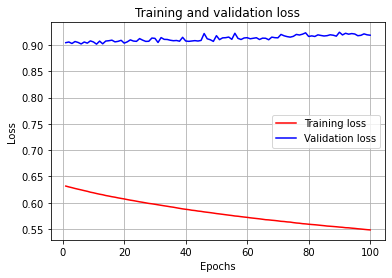

In [78]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들 

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


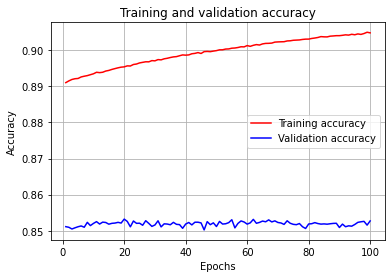

In [79]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들 

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, acc, 'r', label='Training accuracy')
# 파란 실선으로 표시
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.show()

### 모델 테스트
- 인코더

In [80]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 32)          149184    
_________________________________________________________________
masking (Masking)            (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 32), (None, 32),  8320      
Total params: 157,504
Trainable params: 157,504
Non-trainable params: 0
_________________________________________________________________


### 모델 테스트

- 디코더
- 인코더와 디코더의 임베딩층은 서로 다른 임베딩 층을 사용한다
- 디코더의 훈련과 테스트는 같은 임베딩 층을 사용한다

In [81]:
# 디코더 설계
# 이전 시점의 상태롤 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# train 때 사용했던 임베딩 층을 재사용..
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단여 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [82]:
# 디코더 정의
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [83]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_fra[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

## Step 6. 모델 평가하기
단어 단위 번역기에 대해서 훈련 데이터의 샘플과 테스트 데이터의 샘플에 대해서 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요.

### 결과 확인을 위한 함수

In [84]:
def seq2eng(input_seq):
    temp = ''
    for i in input_seq :
        if(i!=0):
            temp = temp + index_to_eng[i] + ' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2fra(input_seq):
    temp = ''
    for i in input_seq:
        if ((i!=0 and i!=fra_to_index['<sos>']) and i!=fra_to_index['<eos>']):
            temp = temp + index_to_fra[i] + ' '
    return temp

### 훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플 결과를 출력

In [102]:
import random
 
a = random.sample(range(1,3000),10) # 1부터 3000까지의 범위중에 10개를 중복없이 뽑겠다.
print(a)

[2436, 695, 2740, 1939, 1837, 2449, 1773, 2041, 226, 1562]


In [103]:
for seq_index in a:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print("원문 : ", seq2eng(encoder_input_train[seq_index]))
    print("번역문 : ", seq2fra(decoder_input_train[seq_index]))
    print("예측문 : ", decoded_sentence[:-5])
    print('\n')


원문 :  i struggled . 
번역문 :  j ai lutt . 
예측문 :   j ai ob je dans la v tre . 


원문 :  cut it in half . 
번역문 :  coupe le en deux . 
예측문 :   la table . 


원문 :  you re very shy . 
번역문 :  vous tes fort timide . 
예측문 :   vous tes tr s timide . 


원문 :  i m letting you go . 
번역문 :  je te lib re . 
예측문 :   je vous m en . 


원문 :  why would he lie ? 
번역문 :  pourquoi mentirait il ? 
예측문 :   pourquoi il en avait l air ? 


원문 :  it freaks me out . 
번역문 :  a me fait flipper . 
예측문 :   a me fait me . 


원문 :  we were all asleep . 
번역문 :  nous dormions tous . 
예측문 :   nous tions tous deux . 


원문 :  i m glad we saw tom . 
번역문 :  je suis content que nous ayons vu tom . 
예측문 :   je suis heureux de nous voir . 


원문 :  i took off my coat . 
번역문 :  je retirai mon manteau . 
예측문 :   je ai bu d un p chez moi . 


원문 :  don t speak so fast . 
번역문 :  ne parlez pas si vite ! 
예측문 :   ce retard ! 




### 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느정도 유사한 프랑스어 번역이 진행되었는지 확인

- 구글 번역기를 통해서 확인해 보았습니다. 

![title](./Google_Transfer.png)


### 평가 루브릭

- 아래의 기준을 바탕으로 프로젝트를 평가합니다.

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. :  구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다. :  seq2seq 모델 훈련결과 validation loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. : 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느정도 유사한 프랑스어 번역이 진행됨을 확인하였다.
